# Visualize Human Pose MPI Dataset

In [1]:
%reload_ext autoreload
%autoreload 2

import os
from os.path import join
import math
from glob import glob
from random import randint

import cv2 as cv
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.io
from pathlib import Path
from sklearn import preprocessing
from tqdm import tqdm_notebook as tqdm

import sys
sys.path.append('/work/megapixels_dev/megapixels/')
from app.settings import app_cfg as cfg
from app.utils import file_utils

In [654]:
# function to create spaced colormaps as RGB values

import matplotlib as mpl
import matplotlib.cm as mplcm
import matplotlib.pyplot as plt
from matplotlib import cm

def get_color_map(cmap='prism', ncolors=20, as_hex=False, reverse=False, bgr=True):
  norm  = mpl.colors.Normalize(vmin=0, vmax=ncolors-1)
  scalars = mplcm.ScalarMappable(norm=norm, cmap=cmap)
  colors = [scalars.to_rgba(i) for i in range(ncolors)]
  colors = [(int(255*c[0]),int(255*c[1]),int(255*c[2])) for c in colors]  
  if reverse:
    colors = colors[::-1]
  if bgr:
    colors = [c[::-1] for c in colors]
  if as_hex:
    colors = ['#{:02x}{:02x}{:02x}'.format(c[0],c[1],c[2]) for c in colors]
  return colors

def jitter_clr(clr, amt=10, mono=False):
  clr = list(clr)
  if mono:
    r = randint(-amt, amt)
    for i in range(len(clr)):
      clr[i] = max(0, min(255, clr[i] + r))
  else:
    for i in range(len(clr)):
      r = randint(-amt, amt)
      clr[i] = max(0, min(255, clr[i] + r))
  return clr

In [3]:
DATA_STORE = '/data_store_nas/'
fp_dataset = join(DATA_STORE, 'datasets/people/youtube_poses')
dir_fp_frames = join(fp_dataset, 'YouTube_Pose_dataset_1.0/GT_frames')

In [4]:
dirs_frames = glob(join(dir_fp_frames, '*'))
fps_frames = {}
for dir_frames in dirs_frames:
  fps_frames[dir_frames] = join(dir_frames, '*')

In [462]:
from pprint import pprint
pprint(list(df_poses.keys()))

['crop_x1',
 'crop_x2',
 'crop_y1',
 'crop_y2',
 'elbow_left_x',
 'elbow_left_y',
 'elbow_right_x',
 'elbow_right_y',
 'head_x',
 'head_y',
 'height',
 'scale',
 'shoulder_left_x',
 'shoulder_left_y',
 'shoulder_right_x',
 'shoulder_right_y',
 'video_id',
 'width',
 'wrist_left_x',
 'wrist_left_y',
 'wrist_right_x',
 'wrist_right_y']


In [681]:
#fp_pose_data = join(fp_dataset, 'YouTube_Pose_dataset_1.0/YouTube_Pose_dataset.mat')
df_poses = pd.read_csv(join(fp_dataset, 'poses.csv'), index_col=0)
#df_poses['index'] = df_poses.index
#df_poses_groups = df_poses.groupby(['video_id'], as_index=True, group_keys=True )
#df_poses_indexed =  df_poses.set_index(['video_id', 'index'], drop=False)
#df_poses = df_poses[0:50]
start = 0
#df_poses = df_poses[start:start+1000]
df_poses.head()

crop_x1  crop_x2  crop_y1  crop_y2  elbow_left_x  elbow_left_y  \
0        1     1920        1     1080    277.721438    192.416331   
1        1     1920        1     1080    273.497648    187.629368   
2        1     1920        1     1080    258.010417    159.752352   
3        1     1920        1     1080    274.342406    188.192540   
4        1     1920        1     1080    272.371304    194.387433   

   elbow_right_x  elbow_right_y      head_x     head_y      ...        \
0     147.628696     169.326277  195.498320  81.471438      ...         
1     152.134073     129.341062  207.324933  72.742272      ...         
2     160.581653     143.138777  229.007056  76.966062      ...         
3     142.841734     110.193212  203.101142  76.402890      ...         
4     225.628024     164.820901  245.902218  93.016465      ...         

   shoulder_left_x  shoulder_left_y  shoulder_right_x  shoulder_right_y  \
0       254.631384       127.088374        178.603159        134.691196   
1       254.349798       131.593750        181.137433        123.990927   
2       250.407594       125.117272        190.992944        117.232863   
3       253.786626       128.777890        185.361223        120.611895   
4       255.476142       139.478159        183.390121        126.806788   

      video_id  width wrist_left_x  wrist_left_y  wrist_right_x  wrist_right_y  
0  -osma2n86oA    720   278.566196    235.498992     158.047379     122.301411  
1  -osma2n86oA    720   274.342406    235.498992     135.238911      91.608535  
2  -osma2n86oA    720   213.801411    108.785282     181.982191      89.074261  
3  -osma2n86oA    720   276.595094    231.556788     156.921035      55.847110  
4  -osma2n86oA    720   305.316868    172.423723     278.284610     165.102487  

[5 rows x 22 columns]

In [682]:
for idx, row in tqdm(df_poses.iterrows()):
  
  idx -= start
  w, h = row['width'], row['height']
  if idx == 0:
    print(row['video_id'])
    print(w,h)
  delta = abs(df_poses['shoulder_left_x'].iloc[idx] - df_poses['shoulder_right_x'].iloc[idx]) / 2
  cx =  df_poses['shoulder_right_x'].iloc[idx] + delta  # body cx
  if idx == 0:
    print('cx', cx)
  offset_x = (w // 2) - cx
  
  delta = abs(df_poses['shoulder_left_y'].iloc[idx] - df_poses['shoulder_right_y'].iloc[idx]) / 2
  cy = df_poses['shoulder_right_y'].iloc[idx] + delta
  # delta again with head
  delta = abs(cy - df_poses['head_y'].iloc[idx]) / 2
  cy -= delta
  offset_y = (h // 2) - cy

  # pandas seems to make setting values during iteration not easy
  for name in row.keys():
    if name.endswith('_x'):
      
      #print(name, 'orig', df_poses.iloc[idx, df_poses.columns.get_loc(name)], '+offset', offset)
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] += offset_x
      #print(name, '+ cx', df_poses.iloc[idx, df_poses.columns.get_loc(name)])
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] -= w // 2
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] /= w
      #df_poses.iloc[idx, df_poses.columns.get_loc(name)] -= .5  # center
      #print(name, 'norm', df_poses.iloc[idx, df_poses.columns.get_loc(name)])
      #print('')

    elif name.endswith('_y'):
    
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] += offset_y  # center
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] -= h // 2  # norm-center
      df_poses.iloc[idx, df_poses.columns.get_loc(name)] /= h  # normalize
      #df_poses.iloc[idx, df_poses.columns.get_loc(name)] -= .5 # center
print(row['video_id'])

-osma2n86oA
720 1280
cx 216.61727150537632

sLOlrDStS7o


In [683]:
df_poses.head()

crop_x1  crop_x2  crop_y1  crop_y2  elbow_left_x  elbow_left_y  \
0        1     1920        1     1080      0.084867      0.064402   
1        1     1920        1     1080      0.077436      0.068252   
2        1     1920        1     1080      0.051820      0.047408   
3        1     1920        1     1080      0.076067      0.068472   
4        1     1920        1     1080      0.073525      0.063522   

   elbow_right_x  elbow_right_y    head_x    head_y      ...        \
0      -0.095817       0.046363 -0.029332 -0.022274      ...         
1      -0.091124       0.022714 -0.014470 -0.021504      ...         
2      -0.083498       0.034428  0.011537 -0.017269      ...         
3      -0.106572       0.007535 -0.022879 -0.018864      ...         
4       0.008604       0.040423  0.036763 -0.015674      ...         

   shoulder_left_x  shoulder_left_y  shoulder_right_x  shoulder_right_y  \
0         0.052797         0.013364         -0.052797          0.019304   
1         0.050842         0.024474         -0.050842          0.018534   
2         0.041260         0.020349         -0.041260          0.014189   
3         0.047518         0.022054         -0.047518          0.015674   
4         0.050060         0.020624         -0.050060          0.010724   

      video_id  width wrist_left_x  wrist_left_y  wrist_right_x  wrist_right_y  
0  -osma2n86oA    720     0.086040      0.098060      -0.081347       0.009625  
1  -osma2n86oA    720     0.078609      0.105650      -0.114590      -0.006765  
2  -osma2n86oA    720    -0.009582      0.007590      -0.053775      -0.007810  
3  -osma2n86oA    720     0.079196      0.102350      -0.087018      -0.034923  
4  -osma2n86oA    720     0.119283      0.046363       0.081738       0.040643  

[5 rows x 22 columns]

In [684]:
#df_poses.plot(x='head_x', y='head_y', style=['o','o'])
#df_poses.plot.scatter(x='head_x', y='head_y')
# df_poses.plot.scatter(x='head_x', y='head_y')
# df_poses.plot.scatter(x='shoulder_left_x', y='shoulder_left_y')
# df_poses.plot.scatter(x='shoulder_right_x', y='shoulder_right_y')
# df_poses.plot.scatter(x='elbow_right_x', y='elbow_right_y')
# df_poses.plot.scatter(x='elbow_left_x', y='elbow_left_y')
# df_poses.plot.scatter(x='wrist_left_x', y='wrist_left_y')
# df_poses.plot.scatter(x='wrist_right_x', y='wrist_right_y')

In [685]:
#df_poses_sm = df_poses[800:900]


In [686]:
joints = [
  ('head_x','head_y'),
  ('wrist_right_x', 'wrist_right_y'),
  ('wrist_left_x', 'wrist_left_y'),
  ('elbow_right_x', 'elbow_right_y'),
  ('elbow_left_x', 'elbow_left_y'),
  ('shoulder_right_x', 'shoulder_right_y'),
  ('shoulder_left_x', 'shoulder_left_y'),
  ]
joint_lines = [ (1, 3), (2, 4), (3, 5), (4, 6)]

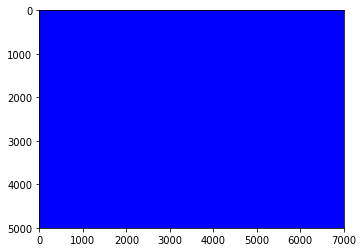

In [773]:
im = np.ones([5000//scalar, 7000//scalar, 3]).astype(np.uint8)
im[::] = (0,0,255)
plt.imshow(im)

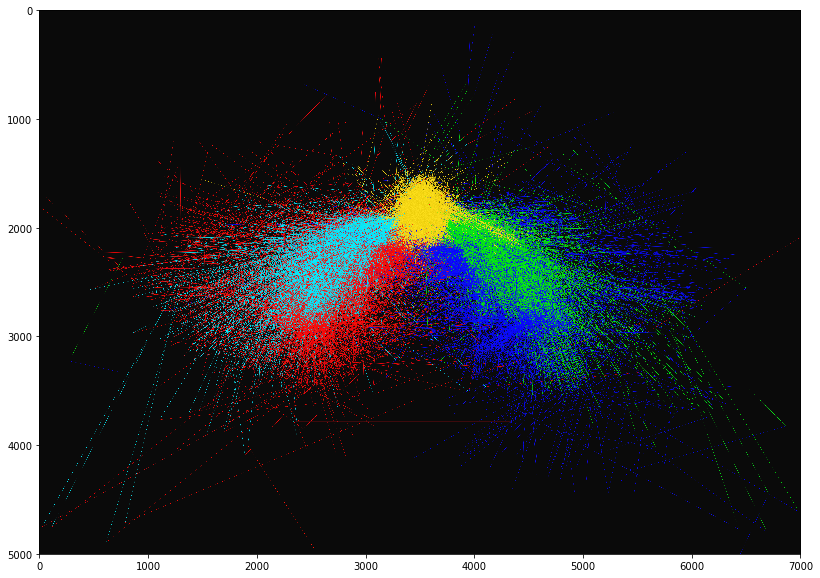

In [778]:
radius = 4
stroke_weight = 1
colors = get_color_map(cmap='spring', ncolors=7, bgr=True, reverse=True)
#colors_lines = get_color_map(cmap='gnuplot2', ncolors=4, bgr=True)
colors = [
  (20,215,245),  # head
  (10,10,250),  # right lower arm
  (250,10,10),  # left lower arm
  (250,230,10),  # right upper arm
  (20,230,5),  # left upper arm
  (10,250,250),  # stage right lower
  (250,10,250),  # stage left lower
]

scalar = 1
im = np.ones([5000//scalar, 7000//scalar, 3]).astype(np.uint8)
im[::] = (10,10,10)
pwh = (im.shape[1] // 1.2, im.shape[0] // 1)

# guides
#cx, cy = im.shape[:2][::-1] // np.array([2])
#cv.line(im, (cx,0), (cx,im.shape[0]), (0,255,0), 2)
#cv.line(im, (0,cy), (im.shape[1], cy), (0,255,0), 2, cv.LINE_AA)

cx, cy = im.shape[:2][::-1] // np.array([2])
cy -= 600

for i, pose in df_poses.iterrows():
  
  # add head
  pt1 = tuple(map(int, (pose[joints[0][0]] * pwh[0] + cx, pose[joints[0][1]] * pwh[1] + cy)))
  # halfway
  
  hcx = abs(pose[joints[6][0]] - pose[joints[1][0]]) / 2 + pose[joints[5][0]]
  hcy = abs(pose[joints[6][1]] - pose[joints[5][1]]) / 2 + pose[joints[5][1]]
  pt2 = tuple(map(int, (hcx * pwh[0] + cx, hcy * pwh[1] + cy)))
  #cv.circle(im, pt1, radius, colors[0], -1, cv.LINE_AA)
  cv.line(im, pt1, pt2, jitter_clr(colors[0], amt=10, mono=True), stroke_weight, cv.LINE_AA)

  for j, joint in enumerate(joints):
    j1, j2 = joint
    pt = tuple(map(int, ((pose[j1] * pwh[0]) + cx, (pose[j2] * pwh[1]) + cy)))
    #cv.circle(im, pt, radius, colors[j], -1, cv.LINE_AA)
  for j,joint in enumerate(joint_lines):
    j1, j2 = joint
    pt1 = tuple(map(int, (pose[joints[j1][0]] * pwh[0] + cx, pose[joints[j1][1]] * pwh[1] + cy)))
    pt2 = tuple(map(int, (pose[joints[j2][0]] * pwh[0] + cx, pose[joints[j2][1]] * pwh[1] + cy)))
    cv.line(im, pt1, pt2, jitter_clr(colors[j+1], amt=10), stroke_weight, cv.LINE_AA)

cv.imwrite('output_norm.png', im)
plt.figure(figsize=(20,10))
plt.imshow(cv.cvtColor(im, cv.COLOR_BGR2RGB))